In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import torch
from tqdm import tqdm

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import ts_ad

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [33]:
log_dir = "./outputs/ts_ad_2"

input_len = 120
output_len = 60

horizon = input_len + output_len
stride = output_len

batch_size = 128

num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [34]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [7]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:13<00:00,  1.87it/s]


In [35]:
train_loader = DataLoader(
    ts_ad.TSADEDataset(data.UnfoldedDataset(m_data_train, horizon=horizon, stride=2*stride), input_len),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    ts_ad.TSADEDataset(data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride), input_len),
    batch_size,
    shuffle=False,
)


# Model

In [36]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
        num_features=data.NUM_FEATURES,
    ),
    backbone_channels=[256, 2048],
    out_feats=data.NUM_FEATURES,
    out_shape=(output_len,)
).float()

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = ts_ad.TSADEngine(
    model=model,
    device=device,
    optimizer=optim,
    lr_scheduler=lr_sched,
)


# Training

In [37]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss = 0.737 - test_loss = 0.738 - test_cost=13.401 - test_threshold=10.056 - lr = 1.00e-03


Epoch 1 - train_loss = 0.686 - test_loss = 0.709 - test_cost=14.026 - test_threshold=10.260 - lr = 9.76e-04


Epoch 2 - train_loss = 0.662 - test_loss = 0.702 - test_cost=14.040 - test_threshold=10.195 - lr = 9.05e-04


Epoch 3 - train_loss = 0.682 - test_loss = 0.698 - test_cost=13.463 - test_threshold=10.172 - lr = 7.94e-04


Epoch 4 - train_loss = 0.638 - test_loss = 0.691 - test_cost=13.820 - test_threshold=10.275 - lr = 6.55e-04


Epoch 5 - train_loss = 0.667 - test_loss = 0.686 - test_cost=13.830 - test_threshold=10.239 - lr = 5.00e-04


Epoch 6 - train_loss = 0.660 - test_loss = 0.684 - test_cost=14.133 - test_threshold=10.244 - lr = 3.45e-04


KeyboardInterrupt: 

In [41]:
backbone = resnet.ResNetFeatures(
    resnet.Bottleneck,
    resnet.RESNET50_LAYERS,
    num_features=data.NUM_FEATURES,
    return_layers=[resnet.LAYER_1, resnet.LAYER_4],
    replace_stride_with_dilation=[False, True, True],
)

In [40]:
import torch.nn.functional as F
feats = backbone(torch.rand(4, 5, 10))

# Compute pairwise cosine similarity on time dimention
cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=2)
print(cos_sim)
# # Mean value over channels
cos_sim = cos_sim.mean(-1)
# Mask out cosine similarity to itself
self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
cos_sim.masked_fill_(self_mask, -9e15)
# Find positive example -> batch_size//2 away from the original example
pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
# InfoNCE loss
cos_sim = cos_sim / 0.5
nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
nll.mean()

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [0.9446, 0.6982, 0.6982, 0.8474, 0.8723, 0.6848, 0.9382, 0.9654,
          0.7223, 0.9451],
         [0.7838, 0.7786, 0.8125, 0.8540, 0.8241, 0.9344, 0.8142, 0.9520,
          0.8192, 0.8498],
         [0.8046, 0.8431, 0.6585, 0.6702, 0.8753, 0.8029, 0.9426, 0.8049,
          0.8906, 0.5138]],

        [[0.9446, 0.6982, 0.6982, 0.8474, 0.8723, 0.6848, 0.9382, 0.9654,
          0.7223, 0.9451],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [0.7719, 0.6994, 0.8801, 0.4999, 0.8702, 0.5830, 0.7841, 0.9414,
          0.3454, 0.9024],
         [0.8941, 0.7883, 0.8934, 0.7652, 0.9449, 0.8929, 0.8512, 0.8391,
          0.9018, 0.5744]],

        [[0.7838, 0.7786, 0.8125, 0.8540, 0.8241, 0.9344, 0.8142, 0.9520,
          0.8192, 0.8498],
         [0.7719, 0.6994, 0.8801, 0.4999, 0.8702, 0.5830, 0.7841, 0.9414,
          0.3

tensor(1.0120)

# Evaluating

In [26]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [27]:
# Cost model
cmodel = metrics.default_cmodel()


In [28]:
scores, labels = get_predictions(engine.predict, test_loader)


100%|██████████| 39/39 [00:18<00:00,  2.16it/s]


In [29]:
cmodel.fit(scores, labels).optimize()


(3.917222214229405, 46.922142)

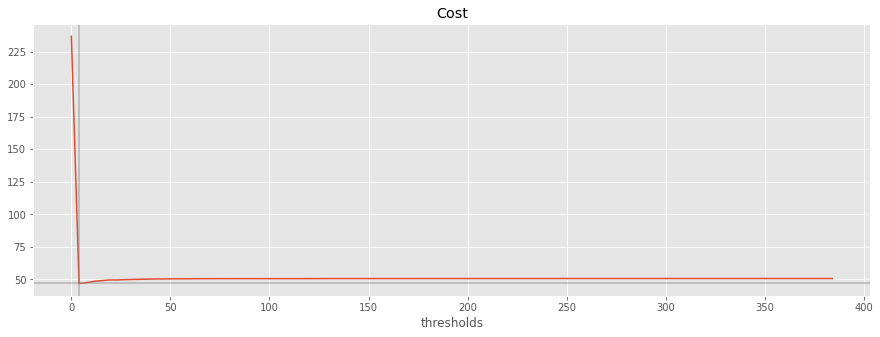

In [30]:
metrics.plot_cost(cmodel)


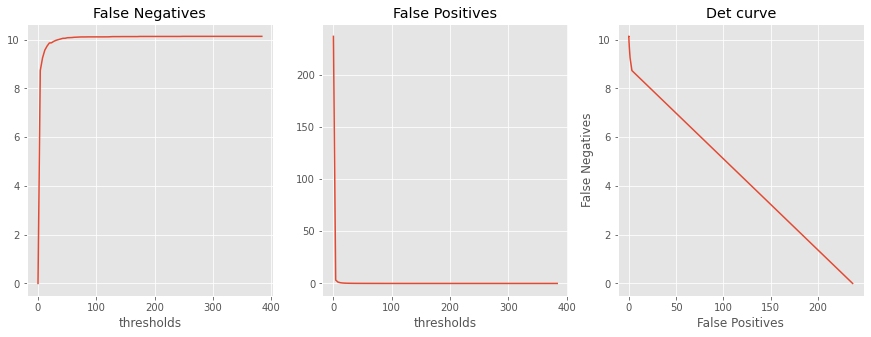

In [31]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


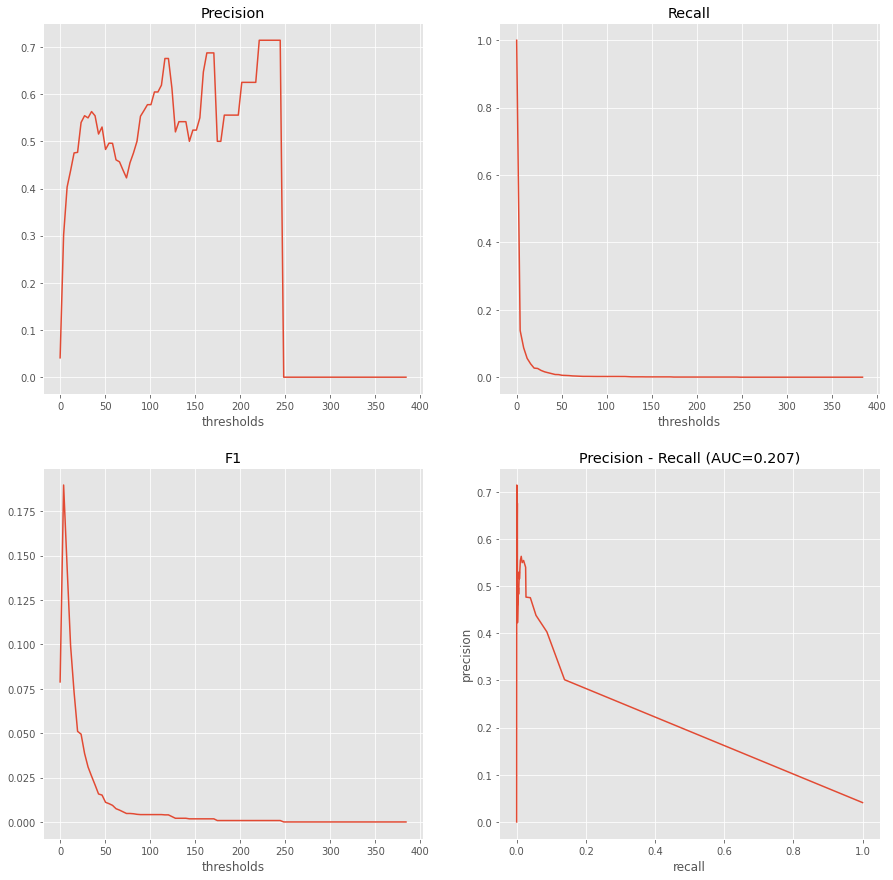

In [32]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)